<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: Ольга Дайховская

# <center> Домашнее задание № 4. Часть 2
## <center>  Прогнозирование популярности статей на TechMedia с помощью линейных моделей

**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/e/1FAIpQLSd8E7naU38ikc9-rd31KeVfez3emCo4Ok1WrpQTr-XCDelRiw/viewform).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#В зависимости от версии sklearn
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv(r'C:\Users\Aleh_Darashenka\Downloads\howpop_train.csv')
test_df  = pd.read_csv(r'C:\Users\Aleh_Darashenka\Downloads\howpop_test.csv')

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

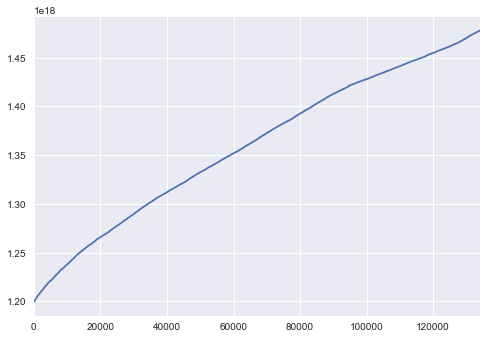

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет
- не знаю

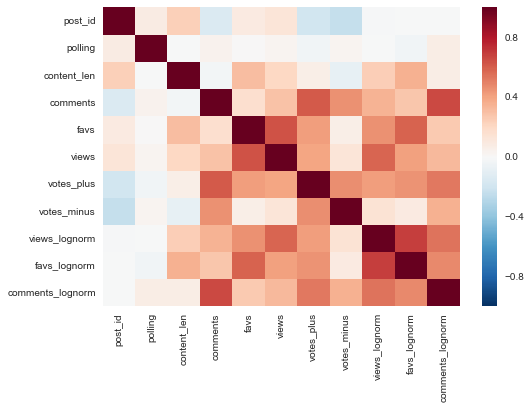

In [6]:
sns.heatmap(train_df.corr())

<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

In [7]:
train_df['published'] = train_df['published'].apply(lambda ts:  pd.to_datetime(ts).value)

In [8]:
new_feature = pd.DataFrame(index=train_df.index)
new_feature['year'] = train_df['published'].apply(lambda ts: pd.to_datetime(ts).year)


In [9]:
new_feature['year'].value_counts()

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: year, dtype: int64

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [10]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [11]:
len(train_df),train_size

(134137, 93895)

In [12]:
X, y = train_df.ix[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.ix[:, features]

In [13]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624
- 93895
- 74378

In [14]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1,3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [16]:
#Можно посмотреть словарь в виде {'термин': индекс признака,...}
print (vectorizer_title.vocabulary_)

{'новогодний': 31497, 'подарок': 36257, 'блоггерам': 14241, 'wordpress': 12172, 'новогодний подарок': 31499, 'сумасшедшие': 45476, 'яйца': 50489, 'или': 22661, 'сервис': 42745, 'для': 18811, 'отслеживания': 34225, 'посетителей': 37373, 'или сервис': 22833, 'сервис для': 42751, 'для отслеживания': 19413, 'или сервис для': 22834, 'сервис для отслеживания': 42753, 'сглаживание': 42460, 'шрифтов': 49862, 'отрисовка': 34214, 'сглаживание шрифтов': 42461, 'почему': 37632, 'мне': 28231, 'не': 30755, 'нравится': 31925, 'iphone': 5951, 'почему мне': 37659, 'мне не': 28233, 'не нравится': 30851, 'всеобщая': 16456, 'доступность': 20285, 'действии': 18272, 'чем': 49165, 'суть': 45504, 'проекта': 39310, 'ru': 9541, 'search': 9842, 'запускается': 21584, 'понедельник': 37201, 'mobile': 7315, 'выбор': 16759, 'способа': 44575, 'связи': 42437, 'обзор': 32095, 'под': 36147, 'windows': 11973, 'под windows': 36185, 'онлайн': 33063, 'банкинг': 13661, 'оформление': 34332, 'рабочего': 40187, 'места': 27821, '

In [17]:
len(vectorizer_title.vocabulary_)

50624

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065
- 15679

In [18]:
vectorizer_title.vocabulary_['python']

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218
- 510
- 125
- 981

In [22]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [24]:
#Здесь так же можно посмотреть словарь
#Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

{' ': 0,
 '!': 1,
 '"': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '(': 8,
 ')': 9,
 '*': 10,
 '+': 11,
 ',': 12,
 '-': 13,
 '.': 14,
 '/': 15,
 '0': 16,
 '1': 17,
 '2': 18,
 '3': 19,
 '4': 20,
 '5': 21,
 '6': 22,
 '7': 23,
 '8': 24,
 '9': 25,
 ':': 26,
 ';': 27,
 '<': 28,
 '=': 29,
 '>': 30,
 '?': 31,
 '@': 32,
 '[': 33,
 '\\': 34,
 ']': 35,
 '^': 36,
 '_': 37,
 '`': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64,
 '{': 65,
 '|': 66,
 '}': 67,
 '~': 68,
 '\x92': 69,
 '\x97': 70,
 '\xa0': 71,
 '£': 72,
 '¥': 73,
 '§': 74,
 '©': 75,
 '«': 76,
 '\xad': 77,
 '®': 78,
 '°': 79,
 '±': 80,
 '²': 81,
 'µ': 82,
 '·': 83,
 '¹': 84,
 '»': 85,
 '¼': 86,
 '½': 87,
 '×': 88,
 'à': 89,
 'á': 90,
 'â': 91,
 'ä': 92,
 'ç': 93,
 'é': 94,
 'ë': 95,
 'ï': 96,
 'ñ': 97,
 'ò': 98,
 'ó': 9

In [23]:
len(vectorizer_title_ch.vocabulary_)

218

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [25]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [26]:
#сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [27]:
#Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
#а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 1: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 2: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 3: {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 4: {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}}

In [28]:
#В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
#поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [29]:
#В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [30]:
#Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.]])

In [31]:
#В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
#Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [32]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть что означает каждая колонка полученной матрицы

In [33]:
#например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к признакам 'author', 'flow', 'domain' X_train и метод transform к тем же признакам X_valid и X_test**

In [35]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())

In [36]:
X_train_feats.shape

(93895, 17869)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [37]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

In [38]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)
#здесь тоже ваш код

Wall time: 9.27 s


In [39]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.184107031582
Ошибка на тесте 0.902647554634


In [57]:
%%time
model2 = Ridge(alpha=3.5938136638046259, random_state=1)
model2.fit(X_train_new, y_train)

Wall time: 3.2 s


In [58]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.398439543031
Ошибка на тесте 0.683352021417


### Подбор параметров

In [56]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': np.logspace(-3,1,10)}
optimizer = GridSearchCV(Ridge(),params, scoring='neg_mean_squared_error', cv=3)
optimizer.fit(full_train_data, y)
print (optimizer.best_score_)
print (optimizer.best_params_)
print (optimizer)

-0.698096708761
{'alpha': 3.5938136638046259}
GridSearchCV(cv=3, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-03,   2.78256e-03,   7.74264e-03,   2.15443e-02,
         5.99484e-02,   1.66810e-01,   4.64159e-01,   1.29155e+00,
         3.59381e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)


## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [59]:
%%time
full_train_data = scipy.sparse.vstack([X_train_new, X_valid_new])
model = Ridge(alpha=3.5938136638046259, random_state=1)

#обучите модель на всех данных
model.fit(full_train_data, y)

test_preds = model.predict(X_test_new)

Wall time: 4.26 s


In [48]:
test_preds

array([ 0.42429065, -1.07599879,  0.66229796, ...,  0.64320715,
        0.02526334,  0.60718918])

In [49]:
sample_submission = pd.read_csv(r'C:\Users\Aleh_Darashenka\Downloads\sample_submission.csv', index_col='url')

In [50]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [60]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
ridge_submission.to_csv('ridge_baseline.csv') #а вот и бейзлайн

In [61]:
ridge_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.428244
https://habrahabr.ru/company/plesk/blog/313732/,-1.010097
https://habrahabr.ru/company/etagi/blog/314000/,0.499940
https://habrahabr.ru/company/knopka/blog/314030/,0.492279
https://geektimes.ru/company/audiomania/blog/282058/,1.065747


In [62]:
train_df.head()

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,1199211540000000000,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,-0.792687,-1.344075,-2.436871
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,1199212200000000000,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,-0.485214,-0.831946,-1.873193
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,1199212440000000000,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,0.446090,1.794023,0.574656
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,1199237520000000000,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,1.627469,1.300050,1.167375
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,1199284440000000000,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,1.362397,0.961094,2.020356


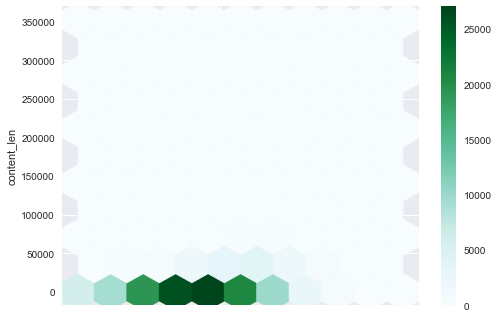

In [89]:
#train_df['log_favs'] = train_df['favs'].apply(lambda ts: np.log(ts+1))
color = np.where(train_df['domain']=='habrahabr.ru', 'b','r')
train_df.plot.hexbin('log_favs','content_len', gridsize=10)

In [73]:
train_df['domain'].unique()

array(['habrahabr.ru', 'geektimes.ru'], dtype=object)

In [75]:
import numpy as np
np.random.rand(50)

array([ 0.40285648,  0.22845355,  0.07015324,  0.72291247,  0.77814366,
        0.87905011,  0.03945692,  0.52886561,  0.3637802 ,  0.38628349,
        0.13385061,  0.1926436 ,  0.13851334,  0.51861231,  0.72388685,
        0.58002862,  0.85936686,  0.70693178,  0.07805257,  0.63902488,
        0.11110763,  0.97223137,  0.72498025,  0.07950196,  0.5055282 ,
        0.21049447,  0.15208352,  0.04037169,  0.73072033,  0.66963056,
        0.00518229,  0.42078715,  0.3637429 ,  0.41281084,  0.51000161,
        0.26907135,  0.22361467,  0.54744512,  0.87019441,  0.6026357 ,
        0.86253869,  0.17402528,  0.25810085,  0.05744116,  0.98210779,
        0.85291481,  0.86650644,  0.30610545,  0.92063905,  0.31014834])